# An alternative alluvial/gravel river model for the Rockies

These are rough notes, assembled Dec 2020 (and maybe modified/extended later) on a potential approach to modeling the long-term evolution of the Rockies (this version last modified 25 Jan 2021).

## Model 1: simple alluvial river without attrition

Assume:

- unlimited supply of gravel sediment (no bedrock)
- comes in two sizes: gravel, and "fines"
- channel width is set by gravel size viz gravel-channel theory
- discharge increases linearly with distance downstream

Here's our equation set:

Conservation of bed sediment = conservation of elevation, $\eta$:

$$\frac{\partial \eta}{\partial t} = -\frac{\partial q_s}{\partial x}$$

Bed-load sediment transport capacity (derives from equilibrium gravel-channel theory; see e.g., Wickert & Schildgen):

$$q_s = -c q \frac{\partial \eta}{\partial x}$$

Here $c$ would be a function of grain size, roughness, and other stuff. The above is just "bedload transport capacity equals coefficient times discharge times slope." We'll assume discharge per unit channel width, $q$, is a runoff factor, $r$, times distance from channel head, $x$: $q = rx$.

Here's a simple numerical solution, with a lowering baselevel at the right:

In [60]:
import numpy as np
import matplotlib.pyplot as plt

dx = 0.01
x = np.arange(0.0, 1.0 + dx, dx)
eta = np.zeros(len(x))
q = x  # discharge = distance downstream (first node is left edge of 0th cell)
qc = np.zeros(len(x))  # first node is left edge of 0th cell
c = 1.0
baselevel_rate = 0.01
dt = 0.2 * dx * dx / c  # time-step size
num_steps = 128000

In [61]:
for t in range(num_steps):
    eta[-1] -= baselevel_rate * dt  # lower baselevel
    S = -np.diff(eta) / dx  # slope gradient
    qc[1:] = c * q[1:] * S  # sediment flux
    eta[:-1] += -(np.diff(qc) / dx) * dt  # continuity     

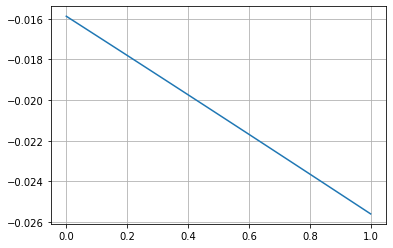

In [62]:
plt.plot(x, eta)
plt.xlabel('Distance downstream')
plt.ylabel('Height')
plt.grid(True)

There's a simple analytical solution here. The equilibrium sediment flux at any $x$ should be:

$$q_s = U x$$

where $U$ is the baselevel rate. Because $q_s = c q S$, we can solve for $S$:

$$S = \frac{Ux}{c q}$$

But here because $q=x$, this becomes simply $S=U/c$. Here's a check:

In [64]:
predicted_slope = baselevel_rate / c
computed_slope = np.mean(S)
print('Predicted = ' + str(predicted_slope))
print('Computed = ' + str(computed_slope))

Predicted = 0.01
Computed = 0.009721949417518312


## Model 2: alluvial river with grain attrition

Here we modify the model to allow grains to be abraded. Our abrasion rule is that a given fraction of the gravel flux gets turned into "fines" per unit travel distance. But because of our capacity rule, any material lost to attrition gets immediately replaced by material on the bed. So this ends up amounting to an "extra" erosion term.

The loss of sediment to attrition over a distance $dx$

$$\frac{\partial \eta}{\partial t} = -\frac{\partial q_s}{\partial x} -\frac{q_s}{\lambda}$$

Here $\lambda$ is a "Sternberg length": the longer it is, the slower grains undergo abrasion. Again, the reason we put this in the bed conservation equation is because sediment is picked up from the bed immediately to replace losses to attrition.

Here's an implementation of that model:

In [142]:
dx = 0.01
c = 1.0
baselevel_rate = 0.01
num_steps = 100000
sternberg_length = 1.0

In [150]:
def evolve_with_attrition(c, dx, sternberg_length):
    x = np.arange(0.0, 1.0 + dx, dx)
    eta = np.zeros(len(x))
    q = x  # discharge = distance downstream (first node is left edge of 0th cell)
    qc = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.2 * dx * dx / c  # time-step size

    for t in range(num_steps):
        eta[-1] -= baselevel_rate * dt  # lower baselevel
        S = -np.diff(eta) / dx  # slope gradient
        qc[1:] = c * q[1:] * S  # sediment flux
        eta[:-1] += -((np.diff(qc) / dx) 
                      + qc[1:] / sternberg_length) * dt

    return eta, qc

0.006238826667798181


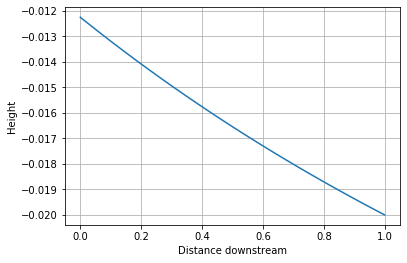

In [151]:
eta1, qc1 = evolve_with_attrition(c, dx, sternberg_length=1.0)

plt.plot(x, eta1)
plt.xlabel('Distance downstream')
plt.ylabel('Height')
plt.grid(True)

This change produces a concave-up profile. We can experiment with how the Sternberg length influences concavity. If we make it really long, it should be close to linear, i.e., the solution in model 1:

9.565040200123012e-05


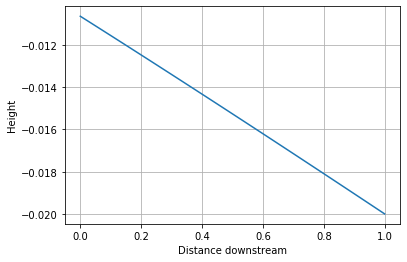

In [152]:
eta100, qc100 = evolve_with_attrition(c, dx, sternberg_length=100.0)

plt.plot(x, eta100)
plt.xlabel('Distance downstream')
plt.ylabel('Height')
plt.grid(True)

0.009999274342628595


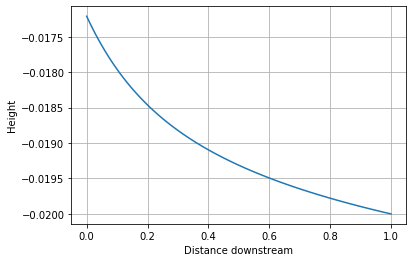

In [153]:
eta0p1, qc0p1 = evolve_with_attrition(c, dx, sternberg_length=0.1)

plt.plot(x, eta0p1)
plt.xlabel('Distance downstream')
plt.ylabel('Height')
plt.grid(True)

We can check this against an analytical solution for sediment flux. We note that at steady state, the amount of gravel the river is carrying should equal the amount produced by erosion upstream, minus the amount lost to attrition. We can find this using an integral: at a given point downstream, $x$, the contribution of sediment from a "patch" of river $dx$ wide at an upstream point a distance $x'$ away should be $U dx \exp (-x'/\lambda )$, where $U$ is the erosion rate. So we integrate over all distances away, from 0 to $x$, to find the total expected sediment discharge:

$$q_s(x) = \int_0^x U e^{-x'/\lambda} dx'$$

$$= U\lambda (1 - e^{-x/\lambda})$$

Let's try it:

Text(0, 0.5, 'Sediment flux')

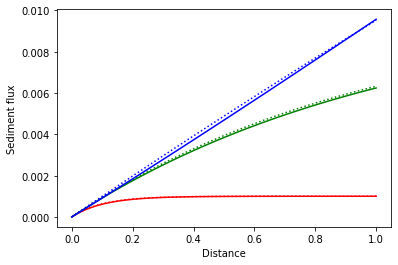

In [156]:
def qexp(x, U, lam):
    return U * lam * (1.0 - np.exp(-x/lam))

plt.plot(x, qc0p1, 'r')
plt.plot(x, qexp(x, baselevel_rate, 0.1), 'r:')
plt.plot(x, qc1, 'g')
plt.plot(x, qexp(x, baselevel_rate, 1.0), 'g:')
plt.plot(x, qc100, 'b')
plt.plot(x, qexp(x, baselevel_rate, 10.0), 'b:')
plt.xlabel('Distance')
plt.ylabel('Sediment flux')

So far so good!

## Model 3: alluvium with bedrock beneath

In this model, we leave aside attrition for the moment and instead consider what happens if there is a layer of bedrock below an alluvial layer of thickness $H$. We'll use a simple stream-power model to erode the bedrock, but with a twist: erosion is limited by alluvial cover. We'll assume the fraction of rock exposed is an exponential function of the alluvial thickness (as in the SPACE model):

$$f_r = e^{-H/H_*}$$

The more sediment there is, the less rock is available for erosion. So our erosion rule is:

$$E = k q S e^{-H/H_*}$$

Meanwhile, our sediment transport is limited by the amount of sediment available:

$$q_c = c q S (1-e^{-H/H_*})$$

This makes our problem more complicated because we now have two dependent variables: elevation, and alluvial thickness. We'll call the elevation of the bedrock surface beneath the alluvium $\eta_b$, such that $\eta = \eta_b + H$.

Our conservation law for alluvium is now:

$$\frac{\partial H}{\partial t} = E - \frac{\partial q_s}{\partial x}$$

The $E$ implies that all erosion of bedrock goes into creating sediment of the same thickness (later we might let some of it disappear into fines; in fact, there's an implied porosity factor that partly does this already, but that's a detail). We now also have a rule for bedrock elevation:

$$\frac{\partial \eta_b}{\partial t} = -E$$

In [354]:
dx = 0.05
c = 1.0
k = 0.01
baselevel_rate = 0.01
num_steps = 1000000
Hstar = 1.0e-1

In [355]:
def evolve_with_bedrock(c, k, dx=0.01, Hstar=1.0, baselevel_rate=0.01):
    x = np.arange(0.0, 1.0 + dx, dx)
    H = Hstar + np.zeros(len(x))  # sediment thickness
    H[-1] = 0.0
    etab = -H
    eta = etab + H
    ero = np.zeros(len(x))  # bedrock erosion rate
    q = x  # discharge = distance downstream (first node is left edge of 0th cell)
    qc = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.2 * dx * dx / c  # time-step size

    for t in range(num_steps):
        eta[-1] -= baselevel_rate * dt  # lower baselevel
        etab[-1] = eta[-1]
        S = -np.diff(eta) / dx  # calc slope gradient
        efac = np.exp(-H / Hstar)
        ero[:-1] = k * q[1:] * S * efac[:-1]  # calc bedrock erosion rate
        qc[1:] = c * q[1:] * S * (1.0 - efac[:-1]) # calc sediment flux
        H[:-1] += (ero[:-1] - (np.diff(qc) / dx)) * dt
        etab[:-1] -= ero[:-1] * dt
        eta[:-1] = etab[:-1] + H[:-1]  # update bed elevation

    return eta, etab, H, qc, ero, x

In [356]:
eta, etab, H, qc, ero, x = evolve_with_bedrock(c, k, dx, Hstar)

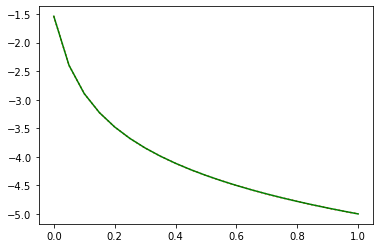

In [357]:
plt.plot(x, etab, 'r:')
plt.plot(x, eta, 'g')

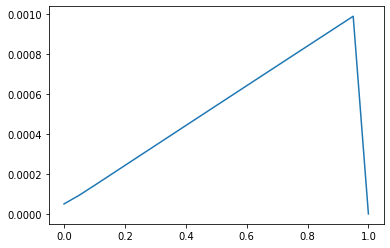

In [358]:
plt.plot(x, H)

So this is really fascinating. The system wants to create a concave-upward profile in which the alluvial thickness increases linearly downstream. Why?

Here's an approach to an analytical solution. At steady state, with erosion rate $U$, the rate of bedrock lowering $E$ must equal the erosion rate (i.e., baselevel lowering rate) $U$. This means:

$$k q S e^{-H'} = U$$

where $H' = H/H_*$. We can rearrange this to solve for $Se^{-H'}$:

$$S e^{-H'} = \frac{U}{kq}\text{ (3.1)}$$

We also know that the sediment flux at any point $x$ must equal the integrated upstream erosion rate, $Ux$. Thus,

$$cqS(1-e^{-H'}) = Ux$$

which we can also solve for $Se^{-H'}$:

$$Se^{-H'} = S - \frac{Ux}{cq} \text{ (3.2)}$$

Equating (3.1) and (3.2), we can solve for $S$:

$$S = \frac{U}{kq} + \frac{Ux}{cq} \text{ (3.3)}$$

If we let $q = rx$ ($r$ being runoff rate), then

$$\boxed{S = \frac{U}{krx} + \frac{U}{cr}}$$

In the limit of large $x$, $S = U/cr$: in other words, the transport slope. In the limit of large $c$, you get a concave-up profile $S \propto 1/x$.

To solve for $H'$, we can return to the rock erosion equation and substitute (3.3) for $S$:

$$e^{H'} = \frac{kqS}{U}$$ 

or

$$H' = \ln \left( \frac{q}{rx} + \frac{kq}{cr} \right)$$

and noting that $q = rx$,

$$\boxed{H' = \ln \left( 1 + \frac{k}{c}x \right)}$$

In the limit of vanishing $k/c$, $H'=0$, which would mean that when the rock is really hard, you need a vanishingly thin alluvial cover. But in general, $H'$ increases downstream as the log of distance.

We can plot these (for $r=1$):


Text(0, 0.5, 'Slope gradient')

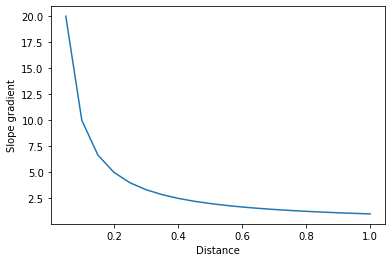

In [371]:
Spred = baselevel_rate * ((1.0/(k * x[1:])) + (1.0/c))
plt.plot(x[1:], Spred)
plt.xlabel('Distance')
plt.ylabel('Slope gradient')

Text(0, 0.5, 'H / H*')

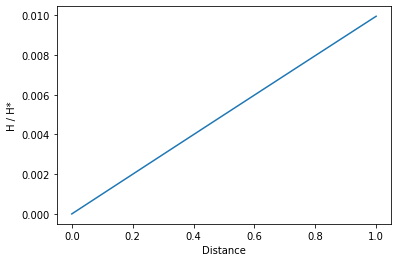

In [375]:
Hpred = np.log(1.0 + (k/c)*x)
plt.plot(x, Hpred)
plt.xlabel('Distance')
plt.ylabel('H / H*')

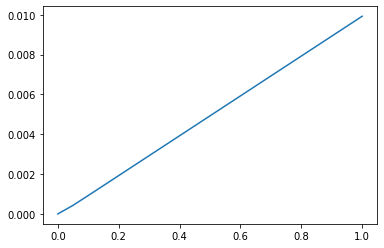

In [359]:
plt.plot(x, qc)

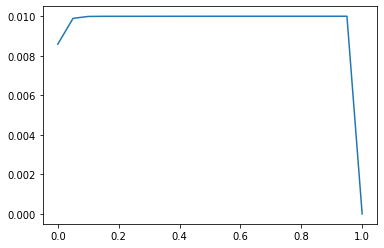

In [360]:
plt.plot(x, ero)

In [361]:
S = np.diff(eta) / dx

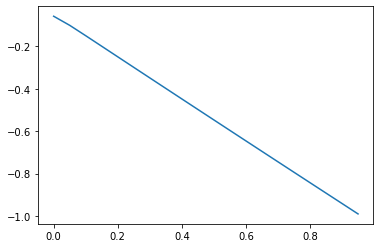

In [362]:
plt.plot(x[:-1], 1/S)

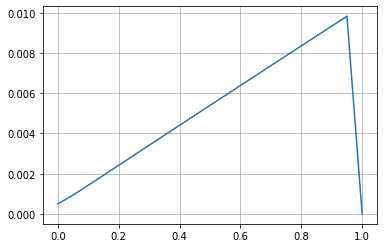

In [363]:
plt.plot(x, 1.0 - np.exp(-H/Hstar))
plt.grid(True)

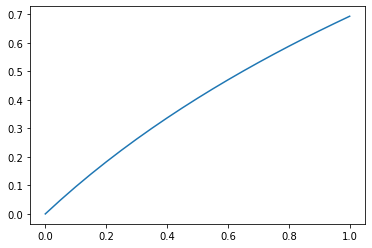

In [364]:
plt.plot(x, np.log(1+x/c))

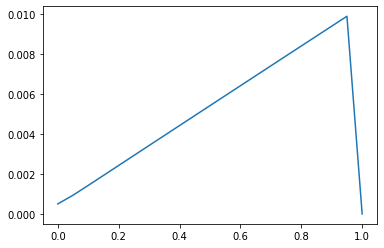

In [365]:
plt.plot(x, H/Hstar)

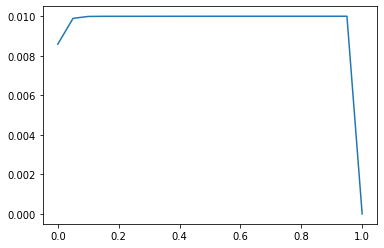

In [366]:
plt.plot(x, ero)

## Model 4: bedrock (and gravel) abrasion

In Model 4, we adopt the abrasion formulation of Chatanantavet and Parker (2009), which is very simple: the lowering rate due to abrasion depends on the coarse sediment flux (per width), $q_s$, multiplied by an abrasion coefficient $\beta$:

$$E_a = \beta q_s$$

If we use this in place of the erosion rule from Model 3, here are our equations:

$$E = E_a e^{-H/H_*} = \beta q_s e^{-H/H_*}$$

Meanwhile, our sediment transport is still based on equilibrium-channel theory, and still limited by the amount of sediment available:

$$q_s = c q S (1-e^{-H/H_*})$$

Combining these,

$$E = \beta c q S (1-e^{-H/H_*}) e^{-H/H_*}$$

One thing that makes it interesting is that the exponential product makes the canonical humped curve: too much sediment on the bed and you cover it; too little and you're starved of tools. This also gives us our equation for bedrock elevation; if we include a term for rock uplift rate (or baselevel lowering), $U$, it is

$$\boxed{\frac{\partial \eta_b}{\partial t} = U - \beta c q S (1-e^{-H/H_*}) e^{-H/H_*}}$$

Here's the conservation law for alluvium, including grain attrition:

$$\frac{\partial H}{\partial t} = \alpha E - \frac{\partial q_s}{\partial x} - \frac{q_s}{\lambda}$$

The factor $\alpha \le 1$, as in C&P (2009), is that fraction of eroded material that goes into coarse load. Substituting our rules above:

$$\frac{\partial H}{\partial t} = \alpha \beta q_s e^{-H/H_*} - \frac{\partial q_s}{\partial x} - \frac{q_s}{\lambda}$$

Rearranging, we find that there is a single term in $q_s$,

$$\frac{\partial H}{\partial t} =  - \frac{\partial q_s}{\partial x} + \left( \alpha \beta  e^{-H/H_*} - \frac{1}{\lambda}\right) q_s$$

but now with a prefactor that could be either negative or positive: positive if the grains are tough ($\lambda \rightarrow \infty$) and/or the rock is weak (large $\beta$); negative if the grains are weak, the rock is strong, and/or the rock abrasion yields little or no coarse sediment (small or zero $\alpha$), etc. C&P (2009) note that $\beta$ "has exactly the same status as the abrasion coefficients used to study downstream fining by abrasion in rivers," and so we might recast our gravel attrition coefficient as $\beta_p = 1/\lambda$ (here $p$ stands for particle). Perhaps if the rock and the grains are made of the same stuff, then $\beta = \beta_p$. In that case, because $\alpha \le 1$, we expect that the prefactor on $q_s$ would be negative (or zero). So with a slight notation change, we have

$$\frac{\partial H}{\partial t} =  - \frac{\partial q_s}{\partial x} - \left( \beta_p - \alpha\beta e^{-H/H_*} \right) q_s$$

We can also express the equation in terms of $q$ and $S$,

$$\boxed{\frac{\partial H}{\partial t} =  - \frac{\partial cqS(1-e^{-H/H_*})}{\partial x} - \left( \beta_p - \alpha\beta e^{-H/H_*} \right) cqS(1-e^{-H/H_*})}$$

...and again, if the rock and grains are made of the same thing, a reasonable conjecture is that $\beta = \beta_p$, and therefore the key factor on the last term is $\beta (1-\alpha e^{-H/H_*})$. In general, we expect this factor to be positive if $H>0$ (as one would expect) because $0 \le \alpha \le 1$.

The next question: what does the solution look like, either at dynamic equilibrium or in a transient?

## Notes on some potentially relevant literature

### Bedrock erosion models

#### Sklar & Dietrich (2004)

They cast saltation-abrasion bed lowering rate as:

$$E = VIF$$

where $V$ is the volume removed per impact, $I$ is the impact rate, and $F$ is the fraction of bedrock exposed. They cast the latter in terms of transport capacity, but let's suppose we want to treat that separately, via a discrete alluvial thickness and an exponential function, or some other method. If I'm going the math right, multiplying their $V$ and $I$ gives:

$$E = \left(\frac{0.08 R_b g Y}{k_v\sigma_T^2}\right) \left( \frac{\tau^*}{\tau_c^*}-1\right)^{-0.5} \left( 1 - \left[ \frac{u_*}{w_f} \right]^2 \right)^{3/2} q_s$$

Arguably the most important element is that $E\propto q_s$, with some factors that depend on transport stage. Note that under the equilibrium channel assumption, $\tau^*/\tau_c^* = 1.2$, and both $u_*$ and $w_f$ are functions of grain size. So you could just cast this as

$$E = s_d q_s$$

They suggest $k_v$ ranges from 1 to 9 times $10^{12}$, depending on lithology, but Chatanantavet & Parker (2009) quote Sklar as later saying this was a typo, and actually it would be more like $10^6$. If we assume quartz and $D\approx 0.05$ m, we get these rough numbers:

- $R_b = 1.65$ buoyant density ratio [-]
- $g = 9.8$
- $Y = 5\times 10^{10}$ Pa, Young's modulus
- $\sigma_T = 7\times 10^6$ Pa, rock tensile strength
- $u_* / w_f = 0.24$ shear ratio, [-] (based on their field site)

From this, we can calculate the Sklar-Dietrich coefficient $s_d$ as:

In [14]:
kv = 1e6
Rb = 1.65
g = 9.8
Y = 5e10
sigt = 7e6
xstage = 0.2
shearrat = 0.24

sd = ((0.08*Rb*g*Y)/(kv*sigt*sigt)) * xstage**(-0.5) * (1-shearrat**2)**1.5

print('Coefficient = ' + str(sd))

Coefficient = 2.7002989623804788e-09


I think the sediment discharge in S&D is in mass/time/width. For a specific sediment discharge of 1 m$^2$/s = 2650 kg/ms, the corresponding rate in mm/yr is:

In [15]:
sd * 2650 * 3600 * 24 * 365.25 * 1000.0

225819.62951832823

...which seems awfully high but then again 1 cms is pretty high too. Overall, the basic conclusion is that $E \propto q_s F$ is a reasonable model. And if you take the above coefficient and multiply by density, you have an $s_d$ for volumetric flux:

In [16]:
sd * 2650

7.155792250308269e-06

#### Chatanantavet & Parker (2009)

Model combines wear/abrasion, plucking, and "macroabrasion." Abrasion sub-model starts by relating coarse-sediment flux to impact rate (volume per area per time) and saltation hop length. Incision rate looks like $E = \beta q_s$, $\beta = r/L_s$ with $r$ being volume removed per imact and $L_s$ saltation hop length. They state that a reasonable range for $\beta$ is 10$^{-4}$ m$^{-1}$ for weak rock, to 10$^{-6}$ m$^{-1}$ for hard rock.

Just to see how realistic this might be, let's take a stream with 5 cm cobbles as the $D_{50}$. Applying equilibrium channel theory plus Meyer-Peter and Mueller. The transport form is:

$$q_s^* = 3.97 (\tau^* - \tau_c^* )^{3/2}$$

with $\tau_c^* = 0.495$ and $\tau^* = 1.2 \tau_c^*$,

$$q_s^* = 3.97 (0.495)^{3/2} 0.2^{3/2}$$

which is:

In [18]:
qsstar = 3.97 * (0.495 * 0.2)**1.5
print(qsstar)

0.1236640024788944


By the definition of $q_s^*$,

$$q_s = \sqrt{R g D^3} q_s^*$$

so:

In [21]:
R = 1.65 # buoyant density ratio
D50 = 0.05 # m
g = 9.8
beta_weak = 1e-4
beta_strong = 1e-6

qs = (R * g * D50**3)**0.5 * qsstar
print('qs = ' + str(qs) + ' m2/s')

wear_rate_strong = beta_strong * qs
wear_rate_weak = beta_weak * qs
print('Wear rate = ' + str(wear_rate_strong) + ' to ' 
      + str(wear_rate_weak) + ' m/s')

qs = 0.005559725057075069 m2/s
Wear rate = 5.559725057075069e-09 to 5.55972505707507e-07 m/s


If bankfull flow persisted for 24 hours during each year, the result rate in m/yr would be:

In [22]:
print(wear_rate_strong * 3600.0 * 24)
print(wear_rate_weak * 3600.0 * 24)

0.00048036024493128596
0.048036024493128604


This of course assumes no limitation due to alluvial bed cover.

For bed cover, they use the same approach as Sklar and Dietrich (1998), i.e., basically fractional cover equals $(1-q_s/q_c)$. They use MPM for capacity.

They treat plucking by conceptualizing a "battering layer" one block thick ($D_a$) on top of an "aging layer" ($L_a$ thick), which has an "aging time" $T_{pa}$. They write conservation laws for these two layers, so it ends up being somewhat analogous to weathering. They call the contribution of impacts to the formation of pluckable blocks in the battering layer "macroabrasion." The rate, in the form of the macroabrasion time scale, is proportional to the sediment flux.

They use a familiar entrainment rate for plucking: $\propto (\tau - \tau_c )^{3/2}$. The plucking erosion rate then becomes this times fraction bedrock exposed times fraction of battering layer that has pluckable blocks. So in a sense it is like stream power but with a kind of weathering function added in.

They have to worry about the upstream boundary condition (sediment influx from divide to channel head). They have a model that they solve in terms of a derived value $B$ as the upstream-integrated flux.

Their model makes concave-up profiles, whether dominated by abrasion or plucking or a combination.

SCRATCH SPACE:

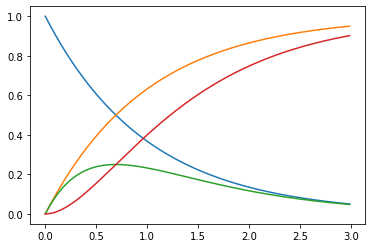

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 3, 0.01)
plt.plot(x, np.exp(-x))
plt.plot(x, 1 - np.exp(-x))
plt.plot(x, np.exp(-x) * (1 - np.exp(-x)))
plt.plot(x, (1-np.exp(-x)) * (1-np.exp(-x)))
